In [1]:
import os
import random
import shutil
from pathlib import Path
import torch
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms
import torchvision.transforms
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import ImageFolder # that can be applied on these datasets

# https://www.kaggle.com/code/vikasbhadoria/mnist-data-99-5-accuracy-using-pytorch/

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # To use to cuda GPU
print(device)

# data/classifier/
# ├── train/
# │   ├── class_0/  (contains images for class 0)
# │   ├── class_1/  (contains images for class 1)
# │   ├── .../
# └── val/
#     ├── class_0/
#     ├── class_1/
#     ├── .../


cuda:0


In [3]:
import os
import shutil
import random
from pathlib import Path
from tqdm import tqdm

input_dir = 'data/mnist_images'  # This is the directory with all 60K .png images
train_dir = 'data/classifier/train' # 10K
val_dir = 'data/classifier/val' # 50K
print(input_dir, train_dir, val_dir)

# Create directories if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

for i in range(10):
    os.makedirs(os.path.join(train_dir, f'class_{i}'), exist_ok=True)
    os.makedirs(os.path.join(val_dir, f'class_{i}'), exist_ok=True)

# Collect all .png files
png_files = list(Path(input_dir).rglob('*.png'))

# Classify files by their label
class_files = {str(i): [] for i in range(10)}
for file in png_files:
    # Extract class label from the filename (class_randomId.png)
    class_label = file.stem.split('_')[0]  # Get the stem (filename without extension) and split on '_'
    if class_label in class_files:
        class_files[class_label].append(file)

# Progress tracking and batch size control
total_train_size = 1000  # Target for the training set
total_val_size = 5000    # Target for the validation set
train_size_per_class = total_train_size // 10  # Target train size per class (1000)
val_size_per_class = total_val_size // 10      # Target validation size per class (5000)

# Set the deviation limit to 30 files
deviation_limit = 30

# Initialize counters for success and failure
success_count = 0
failure_count = 0
failed_files = []  # To keep track of files that failed to move

# Process each class and ensure each has similar numbers of files
for class_label, files in tqdm(class_files.items(), desc="Processing classes", total=10):
    random.shuffle(files)

    # Split into training and validation based on the batch size rules
    class_total = len(files)
    val_count = min(val_size_per_class, class_total - train_size_per_class)
    train_count = class_total - val_count

    # Ensure the deviation limit of ±30
    if abs(train_count - train_size_per_class) > deviation_limit:
        adjustment = (train_count - train_size_per_class) // abs(train_count - train_size_per_class)
        train_count = train_size_per_class + adjustment * deviation_limit
        val_count = class_total - train_count

    # Separate files into validation and training sets
    val_files = files[:val_count]
    train_files = files[val_count:val_count + train_count]

    # Move validation files to the 'val' directory
    for file_path in tqdm(val_files, desc=f"Moving validation files for class {class_label}", leave=False):
        dst_path = os.path.join(val_dir, f'class_{class_label}', file_path.name)  # Use file_path.name for filename
        try:
            shutil.copy(file_path, dst_path)
            success_count += 1
        except Exception as e:
            failure_count += 1
            failed_files.append((file_path, str(e)))  # Store failed file and error

    # Move training files to the 'train' directory
    for file_path in tqdm(train_files, desc=f"Moving training files for class {class_label}", leave=False):
        dst_path = os.path.join(train_dir, f'class_{class_label}', file_path.name)  # Use file_path.name for filename
        try:
            shutil.copy(file_path, dst_path)
            success_count += 1
        except Exception as e:
            failure_count += 1
            failed_files.append((file_path, str(e)))  # Store failed file and error

# Final results
print("\nMove operation completed.")
print(f"Successfully moved: {success_count} files.")
print(f"Failed to move: {failure_count} files.")

# If there were failures, print details
if failure_count > 0:
    print("\nFailed file details:")
    for file, error in failed_files:
        print(f"File: {file}, Error: {error}")


data/mnist_images data/classifier/train data/classifier/val


Processing classes: 100%|██████████| 10/10 [00:02<00:00,  4.35it/s]


Move operation completed.
Successfully moved: 60000 files.
Failed to move: 0 files.


In [4]:
path_train = 'data/classifier/train'
path_val = 'data/classifier/val'

In [5]:
# Define your transformations (Resize, Tensor conversion, and Normalization)
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.Grayscale(num_output_channels=1),  # In case the images are not grayscale
    # transforms.Lambda(lambda img: img.convert('RGB')),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Use ImageFolder to load images from local directories
training_dataset = ImageFolder(root='./data/classifier/train', transform=transform)
validation_dataset = ImageFolder(root='./data/classifier/val', transform=transform)

val_dataset_size = len(validation_dataset)
# Create a subset by specifying indices
# You can select a fixed number or percentage of the dataset for the subset
subset_indices = np.random.choice(val_dataset_size, size=5000, replace=False)  # Subsample 5,000 images
validation_subset_dataset = Subset(validation_dataset, subset_indices)




# Create DataLoader for the training and validation datasets
training_loader = DataLoader(training_dataset, batch_size=100, shuffle=True)
# validation_loader = DataLoader(validation_dataset, batch_size=100, shuffle=False)
validation_loader = validation_subset_loader = DataLoader(validation_subset_dataset, batch_size=100, shuffle=True)

In [6]:
# len(training_dataset)
# len(validation_dataset)
# len(validation_subset_dataset)

In [7]:
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)  # Conv layer1
        self.conv2 = nn.Conv2d(20, 50, 5, 1)  # Conv layer2
        self.fc1 = nn.Linear(50 * 5 * 5, 500)  # Fully connected layer1
        self.dropout1 = nn.Dropout(0.5)  # Dropout layer
        self.fc2 = nn.Linear(500, 10)  # Fully connected layer2
    
    def forward(self, x):
        x = F.relu(self.conv1(x))  # Apply ReLU to Conv1
        x = F.max_pool2d(x, 2, 2)  # Max pooling after Conv1
        x = F.relu(self.conv2(x))  # Apply ReLU to Conv2
        x = F.max_pool2d(x, 2, 2)  # Max pooling after Conv2
        # print(x.shape)  # Debugging print statement
        batch_size = x.size(0)  # Get batch size
        x = x.view(batch_size, -1)  # Flatten the tensor for the fully connected layer

        x = F.relu(self.fc1(x))  # Fully connected layer 1 with ReLU
        x = self.dropout1(x)  # Apply dropout
        x = self.fc2(x)  # Fully connected layer 2 (output)
        return x


In [8]:
model = LeNet().to(device)
model

LeNet(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=1250, out_features=500, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

In [10]:
epochs = 15
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for e in range(epochs):
  
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0
  
  for inputs, labels in training_loader: # As our train_loader is batch size of 100 and had input images and corresponding labels
    inputs = inputs.to(device)  # Put our inputs and labels in the device as our model is also in the device
    labels = labels.to(device)
    outputs = model(inputs)   # giving input to our model to get corresponding output
    loss = criterion(outputs, labels) # comparing out model's output to original labels
    
    optimizer.zero_grad()  ##sets the initial gradient to zero
    loss.backward()  ## The whole calculated loss is then back propogated to the model
    optimizer.step()  ## Then the weights are updated by doing their derivative w.r.t the Loss
    
    _, preds = torch.max(outputs, 1) # Then we select the max value of raw output and consider it as our prediction. We select it from 10 o/ps
    running_loss += loss.item()  # total loss of 1 epoch
    running_corrects += torch.sum(preds == labels.data) #total accuracy of 1 epoch

  else:
    with torch.no_grad(): # This we done to set no gradient as we do not need it for val as our model is already trained.
      for val_inputs, val_labels in validation_loader:
        val_inputs = val_inputs.to(device)  # Put our val_inputs and labels in the device as our model is also in the device
        val_labels = val_labels.to(device)
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)
        
        _, val_preds = torch.max(val_outputs, 1)
        val_running_loss += val_loss.item()
        val_running_corrects += torch.sum(val_preds == val_labels.data)
      
    epoch_loss = running_loss/len(training_loader)
    epoch_acc = running_corrects.float()/ len(training_loader)
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc)
    
    val_epoch_loss = val_running_loss/len(validation_loader)
    val_epoch_acc = val_running_corrects.float()/ len(validation_loader)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)
    print('epoch :', (e+1))
    print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
    print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))

epoch : 1
training loss: 2.2427, acc 25.1905 
validation loss: 2.1469, validation acc 48.1600 
epoch : 2
training loss: 2.0168, acc 55.0952 
validation loss: 1.8247, validation acc 62.7200 
epoch : 3
training loss: 1.6169, acc 66.9048 
validation loss: 1.3718, validation acc 70.1400 
epoch : 4
training loss: 1.1672, acc 71.9048 
validation loss: 0.9868, validation acc 74.5400 
epoch : 5
training loss: 0.8512, acc 76.7143 
validation loss: 0.7566, validation acc 78.8800 
epoch : 6
training loss: 0.6738, acc 79.8571 
validation loss: 0.6375, validation acc 81.2800 
epoch : 7
training loss: 0.5586, acc 82.4762 
validation loss: 0.5588, validation acc 83.8400 
epoch : 8
training loss: 0.4857, acc 84.6190 
validation loss: 0.5097, validation acc 84.5200 
epoch : 9
training loss: 0.4325, acc 87.2857 
validation loss: 0.4767, validation acc 85.6600 
epoch : 10
training loss: 0.4041, acc 87.0000 
validation loss: 0.4372, validation acc 87.2200 
epoch : 11
training loss: 0.3693, acc 88.0000 
va

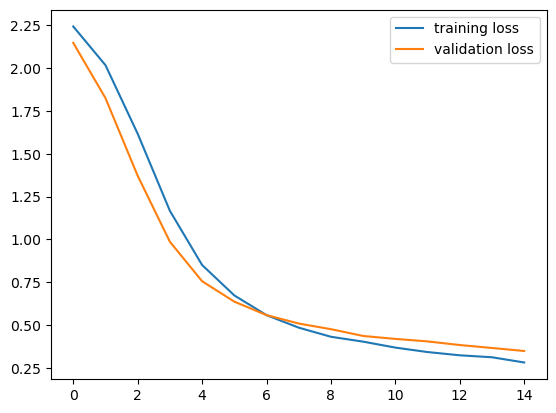

In [11]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

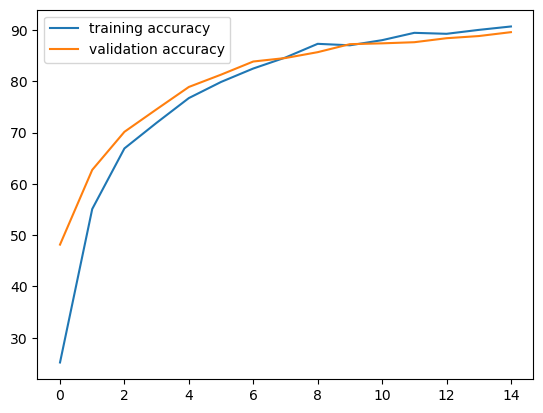

In [12]:
# plt.plot(running_corrects_history, label='training accuracy')
# plt.plot(val_running_corrects_history, label='validation accuracy')
# plt.legend()
import matplotlib.pyplot as plt

# Convert the list of tensors to a list of floats (move to CPU and get the value)
running_corrects_history_cpu = [x.cpu().item() for x in running_corrects_history]
val_running_corrects_history_cpu = [x.cpu().item() for x in val_running_corrects_history]

# Now you can plot them as lists of floats
plt.plot(running_corrects_history_cpu, label='training accuracy')
plt.plot(val_running_corrects_history_cpu, label='validation accuracy')
plt.legend()
plt.show()
